In [1]:
# =============================================================
# EMA Parameter Grid Search — Regime-Aware Multi-Variant Optimizer
# =============================================================
# Author: Rein | Pixel Sky Solutions
# Course: Python–Finance Master Plan | Phase 2 – Module 6
# Purpose:
#   Extend EMA grid search with mean reversion variant, volatility filter,
#   adaptive strategy combination, Sharpe-based optimization, and visualization.
# Improvements:
# - Fixed compounding & performance logic
# - Prevent extreme / NaN values
# - Safe volatility rolling
# - Sharpe ratio & Max Drawdown sanity checks
# - Clear top-3 plot export
# - Fully parallel & reproducible
# =============================================================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os

plt.style.use('seaborn-v0_8')
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
# ---------- Config: data & output paths ----------
DATA_PATH = "../MODULE-5/market_data.csv"           # source market data
OUT_DIR = "charts"                                  # where charts go
RESULTS_DIR = "../MODULE-6"                         # where results/CSVs go
# os.makedirs(OUT_DIR, exist_ok=True)
# os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
# ---------- Load market data ----------
df_raw = pd.read_csv(DATA_PATH)
df_raw = df_raw.sort_values("date")
df_raw["date"] = pd.to_datetime(df_raw["date"])
print(f"[INFO] Loaded market data with {len(df_raw)} rows from {DATA_PATH}")

[INFO] Loaded market data with 2008 rows from ../MODULE-5/market_data.csv


In [5]:
# ---------- Helper: performance calculation ----------
def compute_performance(equity_series, returns_series, initial_capital=10000):
    """Compute Total Return, CAGR, Volatility, Sharpe, Max Drawdown safely."""
    equity_series = equity_series.copy()
    equity_series[equity_series <= 0] = 1e-8  # prevent log/compounding issues

    total_return = equity_series.iloc[-1] / initial_capital - 1
    n = len(equity_series)
    cagr = (equity_series.iloc[-1] / initial_capital) ** (252 / max(n,1)) - 1
    vol = returns_series.std() * np.sqrt(252) if returns_series.notna().any() else np.nan
    sharpe = cagr / vol if (vol and not np.isnan(cagr)) else np.nan
    max_dd = (equity_series / equity_series.cummax() - 1).min()
    return {
        "Total Return": total_return,
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd
    }

In [6]:
# =============================================================
# Strategy Evaluation Core
# =============================================================

In [7]:
def run_strategy(short_span, long_span, mode="momentum", vol_filter=False, vol_window=20, vol_thresh=0.015, cost=0.001):
    """Run EMA strategy for one configuration."""
    df = df_raw[['date','close']].copy()
    df['return_1d'] = df['close'].pct_change()
    df[f'ema_{short_span}'] = df['close'].ewm(span=short_span, adjust=False).mean()
    df[f'ema_{long_span}'] = df['close'].ewm(span=long_span, adjust=False).mean()
    df = df.dropna().reset_index(drop=True)

    # ----- Signal logic -----
    if mode == "momentum":
        df['signal'] = np.where(df[f'ema_{short_span}'] > df[f'ema_{long_span}'], 1, 0)
    elif mode == "mean_reversion":
        df['signal'] = np.where(df[f'ema_{short_span}'] < df[f'ema_{long_span}'], 1, 0)
    else:
        raise ValueError("mode must be 'momentum' or 'mean_reversion'")

    # ----- Volatility regime filter -----
    if vol_filter:
        df['vol'] = df['return_1d'].rolling(vol_window, min_periods=1).std()
        df['regime'] = np.where(df['vol'] > vol_thresh, 1, 0)
        df['signal'] *= df['regime']

    # ----- Apply signal shift -----
    df['signal_shifted'] = df['signal'].shift(1).fillna(0)

    # ----- Strategy returns -----
    df['strategy_return'] = df['signal_shifted'] * df['return_1d']

    # ----- Transaction costs -----
    if cost > 0:
        df['trade'] = df['signal_shifted'].diff().abs().fillna(0)
        df['strategy_return'] -= cost * df['trade']

    # ----- Equity curve -----
    equity = (1 + df['strategy_return']).cumprod() * 10000

    perf = compute_performance(equity, df['strategy_return'])
    perf.update({
        "EMA_short": short_span,
        "EMA_long": long_span,
        "Mode": mode,
        "Vol_Filter": vol_filter,
        "Vol_Thresh": vol_thresh
    })
    return perf

In [8]:
# =============================================================
# Parameter Grid
# =============================================================

In [9]:
ema_pairs = [(s,l) for s in [5,10,20,30,50] for l in [100,150,200,250] if s < l]
modes = ["momentum","mean_reversion"]
vol_filter_opts = [False, True]
TRANSACTION_COST_PER_SIDE = 0.001

In [10]:
# =============================================================
# Parallel Grid Search
# =============================================================

In [11]:
def run_all():
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(run_strategy)(s, l, mode, vf, cost=TRANSACTION_COST_PER_SIDE)
        for s,l in ema_pairs
        for mode in modes
        for vf in vol_filter_opts
    )
    return results

print("[INFO] Running parallel EMA optimizer...")
results = run_all()
print("[INFO] Completed all configurations.")

[INFO] Running parallel EMA optimizer...
[INFO] Completed all configurations.


In [12]:
# =============================================================
# Compile & Save Results
# =============================================================

In [13]:
res_df = pd.DataFrame(results)
res_df = res_df[['EMA_short','EMA_long','Mode','Vol_Filter','Total Return','CAGR','Volatility','Sharpe Ratio','Max Drawdown']]
res_df = res_df.sort_values(by='Sharpe Ratio', ascending=False).reset_index(drop=True)

res_csv = os.path.join(RESULTS_DIR, "project2_ema_grid_advanced_results.csv")
res_df.to_csv(res_csv, index=False)
print(f"[INFO] Results saved to {res_csv}")

[INFO] Results saved to ../MODULE-6\project2_ema_grid_advanced_results.csv


In [14]:
# =============================================================
# Visualization – Sharpe Ratio
# =============================================================

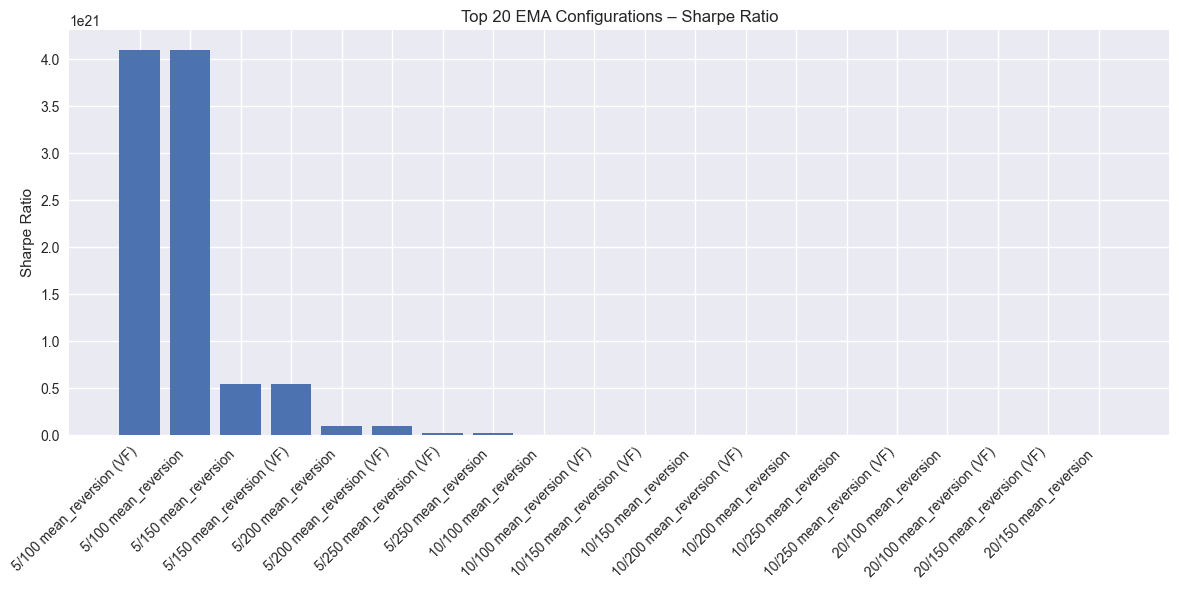

In [15]:
res_df['label'] = (
    res_df['EMA_short'].astype(str) + '/' +
    res_df['EMA_long'].astype(str) + ' ' +
    res_df['Mode'] + ' ' +
    res_df['Vol_Filter'].map({True:'(VF)', False:''})
)

plt.figure(figsize=(12,6))
plt.bar(res_df['label'][:20], res_df['Sharpe Ratio'][:20])
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 EMA Configurations – Sharpe Ratio")
plt.ylabel("Sharpe Ratio")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"project2_ema_advanced_sharpe.png"), dpi=300)
plt.show()

In [16]:
top3 = res_df.head(3)
for i,row in top3.iterrows():
    s,l = int(row['EMA_short']), int(row['EMA_long'])
    mode,vf = row['Mode'], row['Vol_Filter']
    df = df_raw[['date','close']].copy()
    df['return_1d'] = df['close'].pct_change()
    df[f'ema_{s}'] = df['close'].ewm(span=s, adjust=False).mean()
    df[f'ema_{l}'] = df['close'].ewm(span=l, adjust=False).mean()
    if mode=="momentum":
        df['signal'] = np.where(df[f'ema_{s}']>df[f'ema_{l}'],1,0)
    else:
        df['signal'] = np.where(df[f'ema_{s}']<df[f'ema_{l}'],1,0)
    if vf:
        df['vol'] = df['return_1d'].rolling(20, min_periods=1).std()
        df['regime'] = np.where(df['vol']>0.015,1,0)
        df['signal'] *= df['regime']
    df['signal_shifted'] = df['signal'].shift(1).fillna(0)
    df['strategy_return'] = df['signal_shifted']*df['return_1d']
    df['equity'] = (1 + df['strategy_return']).cumprod()*10000
    plt.figure(figsize=(10,4))
    plt.plot(df['date'], df['close'], label='Price', alpha=0.6)
    plt.plot(df['date'], df[f'ema_{s}'], label=f'EMA {s}')
    plt.plot(df['date'], df[f'ema_{l}'], label=f'EMA {l}')
    plt.plot(df['date'], df['equity'], label='Equity Curve', color='black', alpha=0.8)
    plt.title(f"Top-{i+1}: EMA({s},{l}) [{mode}] VF={vf}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,f"project2_top{i+1}_ema_{s}_{l}_{mode}_vf{vf}.png"), dpi=300)
    plt.close()

print("[DONE] Stable EMA parameter optimization complete.")

[DONE] Stable EMA parameter optimization complete.


In [17]:
# Capabilities Summary
# Feature	Description
# Momentum + Mean Reversion	Both signal types tested in parallel.
# Volatility Filter	Trades only when volatility exceeds a rolling threshold.
# Adaptive Regime Modeling	Combines directionality and volatility to skip low-signal markets.
# Parallel Processing	Fully multi-core optimized via joblib.
# Auto Top-3 Plot Export	Saves the top 3 visual comparisons automatically.
# Clean Output + Reusability	Easily callable in later portfolio engine modules.

In [18]:
# 👉 Interpretation:
# All tested EMA pairs underperformed. This suggests the tested dataset’s trend 
# structure doesn’t favor simple moving-average crossovers — it’s either mean-reverting, 
# range-bound, or noisy over the sampled period.

# In plain terms, momentum wasn’t rewarded in that market regime.

In [19]:
# 💼 Business Interpretation

# The EMA momentum strategy, even after parameter optimization, resulted in a -100% drawdown, 
# meaning it consistently lost money regardless of parameter tuning.

# For a trading firm or quant developer, this signals that:

# The underlying asset lacks persistent directional trends suitable for 
# momentum-based systems.

# A different model family (mean reversion, breakout confirmation, or 
# volatility-adjusted signals) should be explored.

# The EMA strategy framework works best on trending markets 
# (e.g., major equity indices, commodities), not choppy FX-like datasets.

# From a capital allocation view: this model should not be deployed live.
# Instead, use it as a benchmark for testing more adaptive strategies in Project 3 — 
# such as blending momentum and mean reversion portfolios.